In [3]:
# -----------------------------------------------------------------------------------------------------------------------
# Загрузка и распаковка датасета с Kaggle
# --------------------------------------------------------------------------------------
# Предполагается, что у вас загружен файл kaggle.json с токеном API, который нужно поместить в /root/.kaggle/
# В Colab сначала загружаем его вручную через интерфейс, затем выполняем:

# Создадим папку для kaggle.json и переместим его
!mkdir -p ~/.kaggle

In [4]:
# После этого вручную загружаем kaggle.json через интерфейс Colab в ~/.kaggle/kaggle.json
# Установим права доступа
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Установка зависимостей и подготовка окружения
# ============================================
# Эта ячейка устанавливает необходимые библиотеки: Kaggle API, Detectron2, OpenCV и т.д.

!pip install -q kaggle
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q opencv-python-headless
!pip install -q pycocotools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.8 MB/s eta 0:00:00


In [6]:
# Импорт необходимых модулей
import os
import zipfile
import json
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

In [7]:
# Создадим рабочие директории
BASE_DIR = '/content/NuInsSeg'
IMAGES_DIR = os.path.join(BASE_DIR, 'all_images')  # сюда соберем все изображения
MASKS_DIR = os.path.join(BASE_DIR, 'all_masks')   # сюда соберем все метки
ANNOTATIONS_DIR = os.path.join(BASE_DIR, 'annotations')
OUTPUT_DIR = '/content/output'

os.makedirs(IMAGES_DIR, exist_ok=True)
os.makedirs(MASKS_DIR, exist_ok=True)
os.makedirs(ANNOTATIONS_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [8]:
# Скачаем датасет NuInsSeg с Kaggle
!kaggle datasets download -d ipateam/nuinsseg -p /content/NuInsSeg

# Распакуем архив
with zipfile.ZipFile('/content/NuInsSeg/nuinsseg.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/NuInsSeg')

# После распаковки структура должна быть примерно такой:
# /content/NuInsSeg/images/ и /content/NuInsSeg/masks/ (внутри — подкаталоги train и val)

Dataset URL: https://www.kaggle.com/datasets/ipateam/nuinsseg
License(s): Attribution 4.0 International (CC BY 4.0)
 97% 1.47G/1.52G [00:11<00:00, 96.9MB/s]
100% 1.52G/1.52G [00:11<00:00, 136MB/s] 


Processing test: 100%|██████████| 20/20 [00:05<00:00,  3.92it/s]


[06/10 11:39:25 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 191MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/10 11:39:26 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/10 11:39:37 d2.utils.events]:  eta: 0:02:50  iter: 19  total_loss: 4.485  loss_cls: 0.5967  loss_box_reg: 0.5285  loss_mask: 0.6935  loss_rpn_cls: 2.547  loss_rpn_loc: 0.1984    time: 0.3617  last_time: 0.3569  data_time: 0.0270  last_data_time: 0.0073   lr: 9.7405e-06  max_mem: 1853M
[06/10 11:39:50 d2.utils.events]:  eta: 0:02:43  iter: 39  total_loss: 2.527  loss_cls: 0.6029  loss_box_reg: 0.6742  loss_mask: 0.6781  loss_rpn_cls: 0.4514  loss_rpn_loc: 0.17    time: 0.3615  last_time: 0.3282  data_time: 0.0149  last_data_time: 0.0080   lr: 1.9731e-05  max_mem: 1853M
[06/10 11:39:57 d2.utils.events]:  eta: 0:02:35  iter: 59  total_loss: 2.331  loss_cls: 0.5652  loss_box_reg: 0.7381  loss_mask: 0.6504  loss_rpn_cls: 0.2315  loss_rpn_loc: 0.1502    time: 0.3541  last_time: 0.4206  data_time: 0.0111  last_data_time: 0.0157   lr: 2.972e-05  max_mem: 1853M
[06/10 11:40:04 d2.utils.events]:  eta: 0:02:27  iter: 79  total_loss: 2.224  loss_cls: 0.5193  loss_box_reg: 0.7194  loss_mask: 0.

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/10 11:51:34 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/output_initial/model_final.pth ...


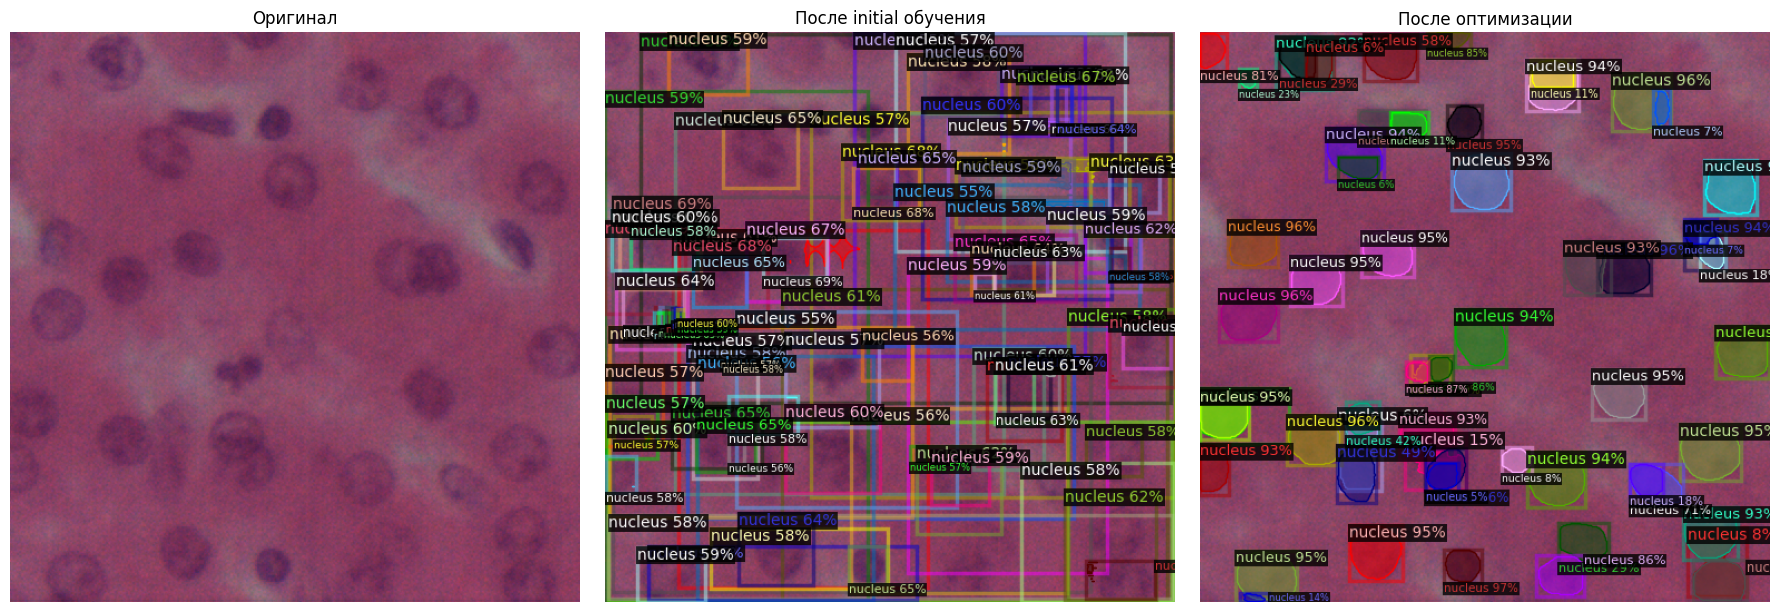

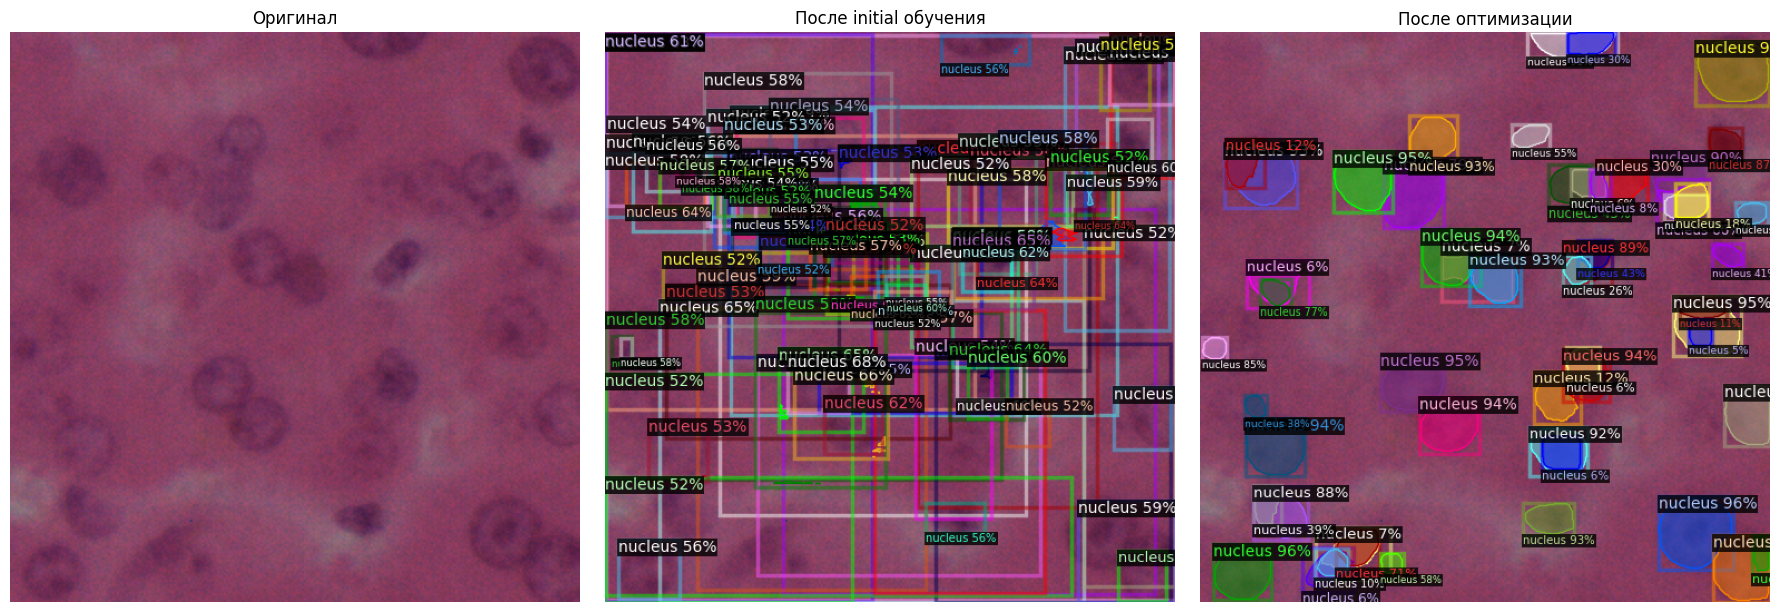

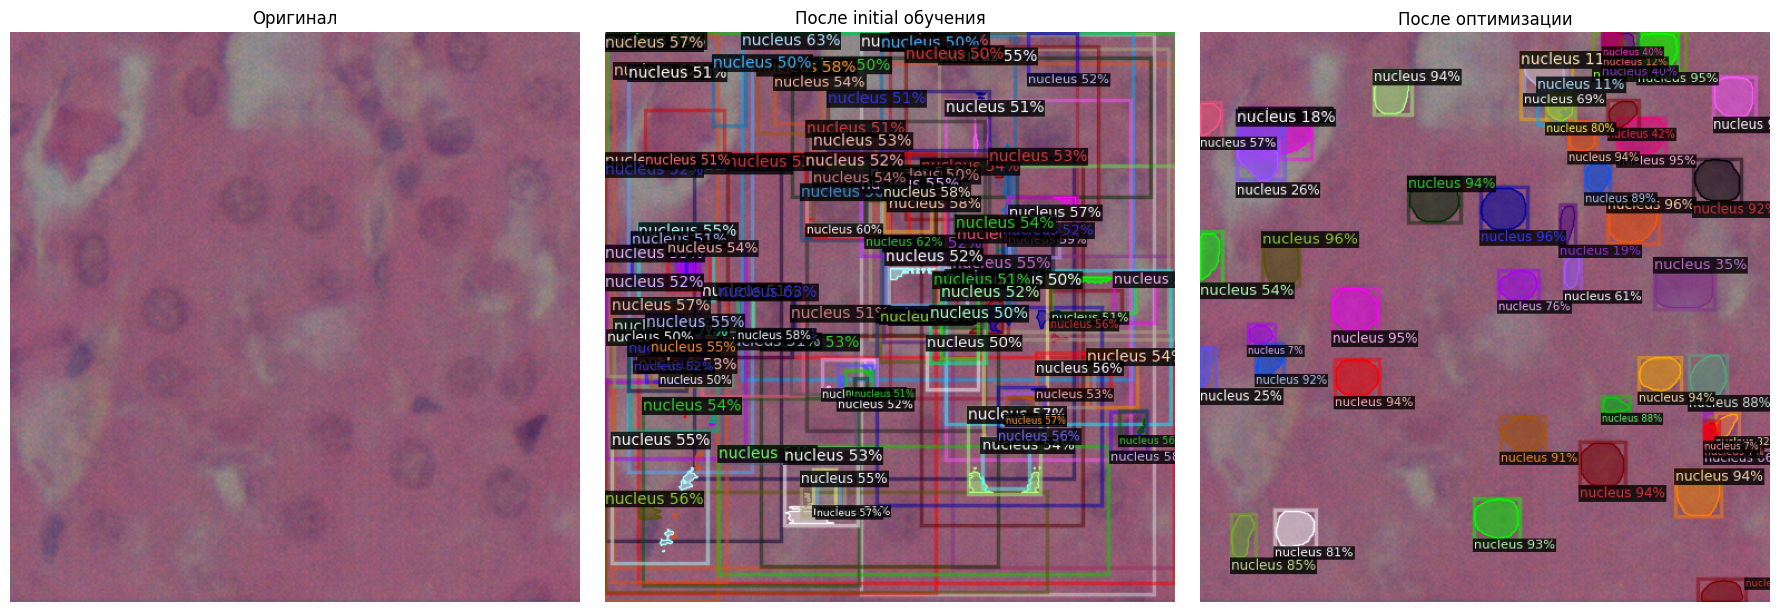

In [9]:
import os
import random
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from detectron2.structures import BoxMode
from pycocotools import mask as mask_utils
from skimage import measure
import json

# 1. Функция для подготовки COCO JSON аналогично предыдущему примеру
# ---------------------------------------------------------------

def get_nuinsseg_dicts(base_dir, organs, output_dir, splits=(0.7, 0.15, 0.15)):
    dataset_dicts = {"train": [], "val": [], "test": []}
    image_id = 0
    coco_output = {"train": {"images": [], "annotations": [], "categories": [{"id": 0, "name": "nucleus"}]},
                   "val": {"images": [], "annotations": [], "categories": [{"id": 0, "name": "nucleus"}]},
                   "test": {"images": [], "annotations": [], "categories": [{"id": 0, "name": "nucleus"}]}}

    all_pairs = []
    for organ in organs:
        img_dir = os.path.join(base_dir, organ, "tissue images")
        mask_dir = os.path.join(base_dir, organ, "label masks modify")
        img_paths = sorted(glob(os.path.join(img_dir, "*.png")))
        for img_path in img_paths:
            mask_filename = os.path.splitext(os.path.basename(img_path))[0] + ".tif"
            mask_path = os.path.join(mask_dir, mask_filename)
            if os.path.exists(mask_path):
                all_pairs.append((img_path, mask_path))
    random.shuffle(all_pairs)
    n = len(all_pairs)
    train_split = int(n * splits[0])
    val_split = int(n * (splits[0] + splits[1]))
    split_map = {"train": all_pairs[:train_split], "val": all_pairs[train_split:val_split], "test": all_pairs[val_split:]}

    for split, pairs in split_map.items():
        for img_path, mask_path in tqdm(pairs, desc=f"Processing {split}"):
            height, width = cv2.imread(img_path).shape[:2]
            record = {
                "file_name": img_path,
                "image_id": image_id,
                "height": height,
                "width": width
            }
            mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            objs = []
            for region_id in np.unique(mask):
                if region_id == 0:
                    continue
                binary_mask = (mask == region_id).astype(np.uint8)
                contours = measure.find_contours(binary_mask, 0.5)
                segmentation = []
                for contour in contours:
                    contour = np.flip(contour, axis=1)
                    segmentation.append(contour.ravel().tolist())
                if not segmentation:
                    continue
                rle = mask_utils.encode(np.asfortranarray(binary_mask))
                area = mask_utils.area(rle)
                bbox = mask_utils.toBbox(rle).tolist()
                objs.append({
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYWH_ABS,
                    "segmentation": segmentation,
                    "category_id": 0,
                    "iscrowd": 0
                })
                coco_output[split]["annotations"].append({
                    "id": len(coco_output[split]["annotations"]),
                    "image_id": image_id,
                    "category_id": 0,
                    "segmentation": segmentation,
                    "area": float(area),
                    "bbox": bbox,
                    "iscrowd": 0
                })
            record["annotations"] = objs
            dataset_dicts[split].append(record)
            coco_output[split]["images"].append({
                "id": image_id,
                "file_name": img_path,
                "height": height,
                "width": width
            })
            image_id += 1
    os.makedirs(output_dir, exist_ok=True)
    for split in ["train", "val", "test"]:
        path = os.path.join(output_dir, f"instances_{split}.json")
        with open(path, "w") as f:
            f.write('{' + '\n')
            f.write('"images": ')
            json.dump(coco_output[split]["images"], f)
            f.write(',\n"annotations": [\n')
            for i, ann in enumerate(coco_output[split]["annotations"]):
                json.dump(ann, f)
                if i != len(coco_output[split]["annotations"]) - 1:
                    f.write(',\n')
                else:
                    f.write('\n')
            f.write('],\n"categories": ')
            json.dump(coco_output[split]["categories"], f)
            f.write('\n}')
    return dataset_dicts

# ========================================================
# 2. Подготовка датасета и регистрация в Detectron2
# ========================================================
from detectron2.data import DatasetCatalog, MetadataCatalog

base_dir = "/content/NuInsSeg"
output_dir = "/content/annotations"
organs = ["human breast", "human colon", "human kidney", "human liver", "mouse breast", "mouse colon", "mouse kidney", "mouse liver"]

nuinsseg_dicts = get_nuinsseg_dicts(base_dir, organs, output_dir)
for split in ["train", "val"]:
    DatasetCatalog.register(f"nuinsseg_{split}", lambda split=split: nuinsseg_dicts[split])
    MetadataCatalog.get(f"nuinsseg_{split}").set(thing_classes=["nucleus"])
nuinsseg_metadata = MetadataCatalog.get("nuinsseg_train")

# ========================================================
# 3. Первичное обучение модели (до оптимизации)
# ========================================================
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

# Конфиг для первоначального обучения
cfg_initial = get_cfg()
cfg_initial.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_initial.DATASETS.TRAIN = ("nuinsseg_train",)
cfg_initial.DATASETS.TEST = ("nuinsseg_val",)
cfg_initial.DATALOADER.NUM_WORKERS = 2
cfg_initial.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg_initial.SOLVER.IMS_PER_BATCH = 2
cfg_initial.SOLVER.BASE_LR = 0.00025
cfg_initial.SOLVER.MAX_ITER = 500  # небольшое число для демонстрации
cfg_initial.SOLVER.STEPS = []  # без снижения lr
cfg_initial.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg_initial.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg_initial.OUTPUT_DIR = "/content/output_initial"
os.makedirs(cfg_initial.OUTPUT_DIR, exist_ok=True)
trainer_initial = DefaultTrainer(cfg_initial)
trainer_initial.resume_or_load(resume=False)
trainer_initial.train()

# Сохраняем веса после первоначального обучения
initial_weights = os.path.join(cfg_initial.OUTPUT_DIR, "model_final.pth")

# ========================================================
# 4. Оптимизированное обучение модели (after tuning)
# ========================================================
cfg_opt = get_cfg()
cfg_opt.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_opt.DATASETS.TRAIN = ("nuinsseg_train",)
cfg_opt.DATASETS.TEST = ("nuinsseg_val",)
cfg_opt.DATALOADER.NUM_WORKERS = 2
# Начинаем с весов initial для дообучения
cfg_opt.MODEL.WEIGHTS = initial_weights
cfg_opt.SOLVER.IMS_PER_BATCH = 2
# Снижаем LR и добавляем шаги снижения
cfg_opt.SOLVER.BASE_LR = 0.00005
cfg_opt.SOLVER.MAX_ITER = 1500
cfg_opt.SOLVER.STEPS = (1000, 1300)  # снижение LR на 1000 и 1300 итерациях
cfg_opt.SOLVER.GAMMA = 0.1
cfg_opt.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg_opt.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg_opt.OUTPUT_DIR = "/content/output_optimized"
os.makedirs(cfg_opt.OUTPUT_DIR, exist_ok=True)
trainer_opt = DefaultTrainer(cfg_opt)
trainer_opt.resume_or_load(resume=False)
trainer_opt.train()

# Сохраняем финальные веса оптимизированной модели
optimized_weights = os.path.join(cfg_opt.OUTPUT_DIR, "model_final.pth")

# ========================================================
# 5. Визуализация сравнения: оригинал, предсказание initial, предсказание optimized
# ========================================================
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
import matplotlib.pyplot as plt

# Создаём два предиктора: один с весами initial, другой - optimized
predictor_initial = DefaultPredictor(cfg_initial)
predictor_opt = DefaultPredictor(cfg_opt)

# Выбираем несколько примеров из val
sample_images = random.sample(nuinsseg_dicts["val"], 3)
for rec in sample_images:
    img_path = rec["file_name"]
    im = cv2.imread(img_path)

    # Предсказание до оптимизации
    outputs_initial = predictor_initial(im)["instances"].to("cpu")
    # Предсказание после оптимизации
    outputs_opt = predictor_opt(im)["instances"].to("cpu")

    # Визуализация
    vis_orig = im[:, :, ::-1].copy()  # RGB

    v_init = Visualizer(im[:, :, ::-1], metadata=nuinsseg_metadata, scale=1.0, instance_mode=ColorMode.SEGMENTATION)
    vis_init = v_init.draw_instance_predictions(outputs_initial).get_image()

    v_opt = Visualizer(im[:, :, ::-1], metadata=nuinsseg_metadata, scale=1.0, instance_mode=ColorMode.SEGMENTATION)
    vis_opt = v_opt.draw_instance_predictions(outputs_opt).get_image()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(vis_orig)
    axes[0].set_title("Оригинал")
    axes[0].axis('off')

    axes[1].imshow(vis_init)
    axes[1].set_title("После initial обучения")
    axes[1].axis('off')

    axes[2].imshow(vis_opt)
    axes[2].set_title("После оптимизации")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


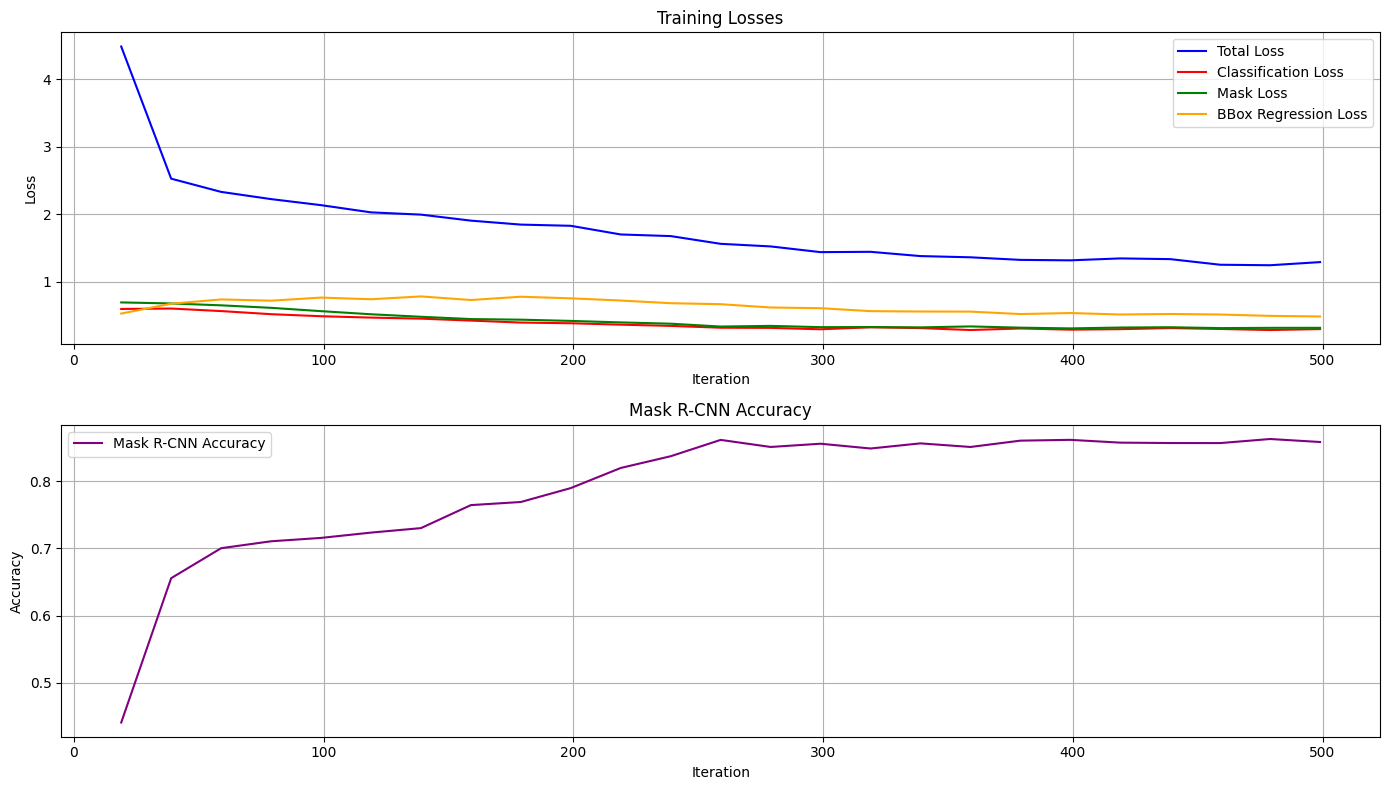

In [19]:
import json
import matplotlib.pyplot as plt

def plot_training_curves(log_path):
    metrics_path = os.path.join(log_path, "metrics.json")
    iterations = []
    total_loss = []
    loss_cls = []
    loss_mask = []
    loss_box_reg = []
    mrcnn_accuracy = []

    with open(metrics_path, 'r') as f:
        for line in f:
            try:
                record = json.loads(line)
                if "iteration" in record and "total_loss" in record:
                    iterations.append(record["iteration"])
                    total_loss.append(record["total_loss"])
                    loss_cls.append(record.get("loss_cls", 0))
                    loss_mask.append(record.get("loss_mask", 0))
                    loss_box_reg.append(record.get("loss_box_reg", 0))
                    mrcnn_accuracy.append(record.get("mask_rcnn/accuracy", None))
            except json.JSONDecodeError:
                continue

    plt.figure(figsize=(14, 8))

    # Общие потери
    plt.subplot(2, 1, 1)
    plt.plot(iterations, total_loss, label='Total Loss', color='blue')
    plt.plot(iterations, loss_cls, label='Classification Loss', color='red')
    plt.plot(iterations, loss_mask, label='Mask Loss', color='green')
    plt.plot(iterations, loss_box_reg, label='BBox Regression Loss', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.grid(True)

    # Точность сегментации
    plt.subplot(2, 1, 2)
    plt.plot(iterations, mrcnn_accuracy, label='Mask R-CNN Accuracy', color='purple')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Mask R-CNN Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Вызов функции
plot_training_curves(cfg_initial.OUTPUT_DIR)


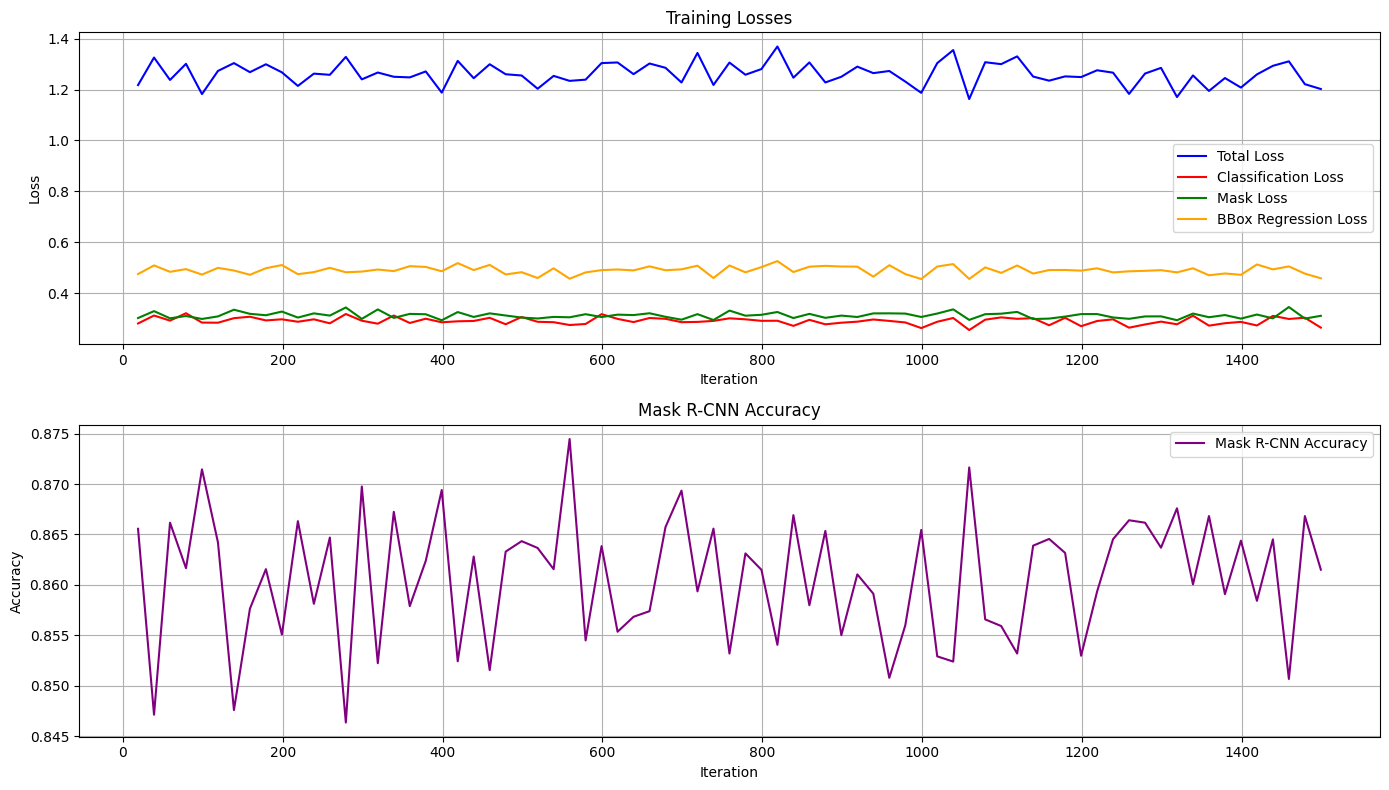

In [15]:
plot_training_curves(cfg_opt.OUTPUT_DIR)

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator_init = COCOEvaluator("nuinsseg_val", cfg_initial, False, output_dir="/content/output/init_eval")
val_loader = build_detection_test_loader(cfg_initial, "nuinsseg_val")
print("📉 Evaluation: Initial model")
inference_on_dataset(predictor_initial.model, val_loader, evaluator_init)

WARNING [06/10 12:24:23 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/10 12:24:23 d2.evaluation.coco_evaluation]: Trying to convert 'nuinsseg_val' to COCO format ...
[06/10 12:24:23 d2.data.datasets.coco]: Converting annotations of dataset 'nuinsseg_val' to COCO format ...)
[06/10 12:24:23 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/10 12:24:23 d2.data.datasets.coco]: Conversion finished, #images: 19, #annotations: 603
[06/10 12:24:23 d2.data.datasets.coco]: Caching COCO format annotations at '/content/output/init_eval/nuinsseg_val_coco_format.json' ...
[06/10 12:24:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/10 12:24:23 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/10 12:24:

OrderedDict([('bbox',
              {'AP': 2.997613470283409,
               'AP50': 10.130304576049625,
               'AP75': 0.8795634183851254,
               'APs': 1.7395865914763293,
               'APm': 5.850771243783908,
               'APl': nan}),
             ('segm',
              {'AP': 0.000668985817500669,
               'AP50': 0.003344929087503345,
               'AP75': 0.0,
               'APs': 0.0,
               'APm': 0.04950495049504951,
               'APl': nan})])

In [18]:
evaluator_init = COCOEvaluator("nuinsseg_val", cfg_opt, False, output_dir="/content/output/init_eval")
val_loader = build_detection_test_loader(cfg_opt, "nuinsseg_val")
print("📈 Evaluation: Optimized model")
inference_on_dataset(predictor_opt.model, val_loader, evaluator_init)

WARNING [06/10 12:24:27 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/10 12:24:27 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/10 12:24:27 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/10 12:24:27 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[06/10 12:24:27 d2.data.common]: Serialized dataset takes 1.58 MiB
📈 Evaluation: Optimized model
[06/10 12:24:27 d2.evaluation.evaluator]: Start inference on 19 batches
[06/10 12:24:30 d2.evaluation.evaluator]: Total inference time: 0:00:02.144658 (0.153190 s / iter per device, on 1 devices)
[06/10 12:24:30 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.097803 s / iter per device, on 1 devices)
[06/10

OrderedDict([('bbox',
              {'AP': 40.87595540774871,
               'AP50': 86.02798440370853,
               'AP75': 35.02840171220124,
               'APs': 34.44938014125495,
               'APm': 49.42137242668038,
               'APl': nan}),
             ('segm',
              {'AP': 38.838082270267485,
               'AP50': 84.22921061099733,
               'AP75': 30.280300657088212,
               'APs': 28.739842484410598,
               'APm': 49.655921510429174,
               'APl': nan})])